## Useful libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch_geometric
import sklearn

In [2]:
## TODO: https://medium.com/math-simplified/checking-for-linear-dependence-in-sympy-9776b66dbe75

## Utility functions

In [3]:
def categorize_columns(df, columns):
    for column in columns:
        df[column] = df[column].astype("category")
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [4]:
def z_scale(df_z_scaled, columns): ## is a bit better for neural networks
    for column in columns:
        df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()   
    return df_z_scaled

In [5]:
from pandas.api.types import is_numeric_dtype
def remove_uninformative_columns(df, columns):
    ## removes categorcial columns where we have no duplicates (i.e., columns with all different categorical values like ids)
    filtered_columns = []
    for column in columns:
        all_values_in_column_identical = df[column].unique().shape[0] < 2
        if all_values_in_column_identical:
            continue
        category_has_duplicates = df.duplicated(subset=column).sum()> 0 ##is informative
        if category_has_duplicates or is_numeric_dtype(df[column]) :
            filtered_columns.append(column)
    return filtered_columns

In [6]:
import torch
def reverse_edge_index(torch_tensor):
    reversed_torch_tensor = torch.zeros_like(torch_tensor)
    reversed_torch_tensor[:, 0] = torch_tensor[:, 1]
    reversed_torch_tensor[:, 1] = torch_tensor[:, 0]
    return reversed_torch_tensor

## What we need
- Gene node feature #genes x #features
- Model node feature #models x features (for now includes drug inofrmation and the drug IC50 target for simplicity) (more complicated than I expected)
  -> later edge attribute prediction?
- Gene_model_edge_index_cn #edges x 2
- Gene_model_edge_index_mutations #edges x 2
- Gene_model_edge_index_geneexpressions #edges x 2
- Gene_model_edge_attributes_cn #edges x #attributes
- Gene_model_edge_attributes_mutations #edges x #attributes
- Gene_model_edge_attributes_geneexpressions #edges x #attributes

  Het-GAT for regression task with MSE as loss

## Read human genome

In [7]:
human_genome = pd.read_csv("human_genome.tsv", sep="\t", header=None) ## merging via gene symbol
human_genome["human_genome_index"] = human_genome.index
human_genome.head()

,0,1,2,3,human_genome_index
0,hsa:102466751,miRNA,1:complement(17369..17436),"MIR6859-1, hsa-mir-6859-1; microRNA 6859-1",0
1,hsa:100302278,miRNA,1:30366..30503,"MIR1302-2, MIRN1302-2, hsa-mir-1302-2; microRN...",1
2,hsa:79501,CDS,1:65419..71585,OR4F5; olfactory receptor family 4 subfamily F...,2
3,hsa:102465909,miRNA,1:complement(187891..187958),"MIR6859-2, hsa-mir-6859-2; microRNA 6859-2",3
4,hsa:112268260,CDS,1:complement(365134..382235),uncharacterized LOC112268260,4


## Get gene symbols to human genome index dataframe (is in nested list semicolon, comma separated)

In [8]:
def get_gene_idx_to_gene_symbol(human_genome):
    sem_split = human_genome[3].str.split("; ")
    comma_split = sem_split.map(lambda n: n[0]).str.split(",")
    exploded_gene_symbols = comma_split.explode().str.strip().to_frame()
    exploded_gene_symbols = exploded_gene_symbols.rename(columns={3:"symbol"})
    exploded_gene_symbols["human_genome_index"] = exploded_gene_symbols.index
    exploded_gene_symbols = exploded_gene_symbols.reset_index(drop=True)
    return exploded_gene_symbols

In [9]:
gene_idx_to_gene_symbol_df = get_gene_idx_to_gene_symbol(human_genome)

## Generate nodes features for gene nodes

In [10]:
def get_gene_features(human_genome):
    categorize_columns(human_genome, human_genome.columns[:3])
    z_scale(human_genome, human_genome.columns[:3])
    gene_features = human_genome.loc[:, :2].values
    return gene_features

In [11]:
gene_features = get_gene_features(human_genome)

In [12]:
gene_features.shape

(24689, 3)

## Generate node features for models (with target) and target labels

In [13]:
targets = pd.read_csv("target.csv",sep=";")
models = pd.read_csv("model_list_20240110.csv")
models.head()

,model_id,sample_id,patient_id,parent_id,model_name,synonyms,tissue,cancer_type,cancer_type_ncit_id,tissue_status,...,msh6_expression_by_ihc,braf_mutation_identified,braf_expression_by_ihc,pik3ca_mutation_identified,pten_expression_by_ihc,pten_mutation_identified,kras_mutation_identified,mismatch_repair_status,preoperative_ce_alevel,crispr_ko_data
0,SIDM01774,SIDS01659,SIDP01578,NaN,PK-59,NaN,Pancreas,Pancreatic Carcinoma,C3850,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,SIDM00192,SIDS00612,SIDP00541,NaN,SNU-1033,NaN,Large Intestine,Colorectal Carcinoma,C9383,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,SIDM01447,SIDS01466,SIDP01347,NaN,SNU-466,NaN,Central Nervous System,Glioblastoma,C3058,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,SIDM01554,SIDS01363,SIDP01247,NaN,IST-MES-2,NaN,Lung,Mesothelioma,C45662,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,SIDM01689,SIDS01631,SIDP01557,NaN,MUTZ-5,NaN,Haematopoietic and Lymphoid,B-Lymphoblastic Leukemia,C8644,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [14]:
def get_transformed_merged_drug_model_df(models, targets):
    columns_with_most_val_filled = models.columns[models.isnull().sum(axis=0)/ models.shape[0] <= 0.1]
    filtered_columns = remove_uninformative_columns(models, columns_with_most_val_filled) ##all categorical
    filtered_columns.append("model_id") ## required for later join
    print(filtered_columns)
    models = models[filtered_columns].fillna("Unkown")
    columns_besides_id = list(filter(lambda x: x != "model_id", filtered_columns))
    models = categorize_columns(models, columns_besides_id)
    z_scale(models, columns_besides_id)
    models = models.rename(columns={"model_id":"SANGER_MODEL_ID"}) ##rename for join
    limited_drug_target = targets[targets["DRUG_ID"] == 1862] ##filter specific drug
    limited_drug_target_filtered = limited_drug_target.loc[:, ["CELL_LINE_NAME", "SANGER_MODEL_ID", "MIN_CONC", "LN_IC50"]]
    limited_drug_target_filtered = categorize_columns(limited_drug_target_filtered, ["CELL_LINE_NAME"])
    z_scale(limited_drug_target_filtered, list(filter(lambda x: x not in ["LN_IC50", "SANGER_MODEL_ID"], limited_drug_target_filtered.columns)))
    model_drug_information = pd.merge(limited_drug_target_filtered, models, how="inner", on="SANGER_MODEL_ID") ## merge drug and model information
    model_drug_information["model_idx"] = model_drug_information.index ##store index for later joins to retrieve edge index
    return model_drug_information

In [15]:
merged_drug_model_df = get_transformed_merged_drug_model_df(models,  targets)

['sample_id', 'patient_id', 'model_name', 'tissue', 'cancer_type', 'cancer_type_ncit_id', 'tissue_status', 'sample_site', 'cancer_type_detail', 'model_type', 'growth_properties', 'gender', 'ethnicity', 'smoking_status', 'sample_treatment', 'crispr_ko_data', 'model_id']


In [16]:
def get_target_label_and_model_with_target_feature(model_drug_information):
    target_labels = model_drug_information.pop("LN_IC50").values
    model_feature_columns = list(filter(lambda x: x not in ["model_idx", "SANGER_MODEL_ID"], model_drug_information.columns))
    print(model_feature_columns)
    model_and_target_features = model_drug_information[model_feature_columns].values
    return (target_labels, model_and_target_features)

In [17]:
target_labels, model_and_target_features = get_target_label_and_model_with_target_feature(merged_drug_model_df)

['CELL_LINE_NAME', 'MIN_CONC', 'sample_id', 'patient_id', 'model_name', 'tissue', 'cancer_type', 'cancer_type_ncit_id', 'tissue_status', 'sample_site', 'cancer_type_detail', 'model_type', 'growth_properties', 'gender', 'ethnicity', 'smoking_status', 'sample_treatment', 'crispr_ko_data']


In [18]:
target_labels.shape, model_and_target_features.shape

((969,), (969, 18))

## Generate edge indices and edge attributes

### Read copy numbers

In [19]:
copy_numbers = pd.read_csv("WES_pureCN_CNV_genes_20220623.csv")
copy_numbers.head()

,model_name,model_id,symbol,gene_id,chr_name,chr_start,chr_end,total_copy_number,minor_copy_number,loh,...,seg_mean,gene_mean,num_targets,focal,breakpoints,num_snps,gatk_mean_log2_copy_ratio,comment,source,data_type
0,MEC-1,SIDM00001,ABCB1,SIDG00064,chr7,87503966,87600461,3.0,1.0,False,...,0.599167,0.414125,28.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES
1,MEC-1,SIDM00001,ABL1,SIDG00150,chr9,130714099,130885948,3.0,1.0,False,...,0.599167,0.472693,12.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES
2,MEC-1,SIDM00001,BRD3,SIDG02504,chr9,134033313,134053689,3.0,1.0,False,...,0.599167,0.705704,11.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES
3,MEC-1,SIDM00001,CARD11,SIDG03455,chr7,2906361,2958783,3.0,1.0,False,...,0.599167,0.696245,23.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES
4,MEC-1,SIDM00001,CDK6,SIDG04156,chr7,92614869,92833599,3.0,1.0,False,...,0.599167,0.750720,7.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES


### Get edge index (model-[CopyNumbers]->gene)

In [20]:
def get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, df):
    human_genome_index_merged_df = pd.merge(gene_idx_to_gene_symbol_df, df, on="symbol", how = "inner")
    human_genome_index_merged_df = human_genome_index_merged_df.rename(columns={"model_id": "SANGER_MODEL_ID"}) ##rename for join
    model_gene_merged_df = pd.merge(human_genome_index_merged_df, merged_drug_model_df, on="SANGER_MODEL_ID", how="inner")
    return model_gene_merged_df

In [21]:
model_gene_merged_copy_number_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, copy_numbers)
model_to_gene_copy_number_edge_index = model_gene_merged_copy_number_df.loc[:, ["model_idx", "human_genome_index"]].values.astype(np.int64)
model_to_gene_copy_number_edge_index.shape

(887292, 2)

### Get edge attributes (model-[CopyNumbers]->gene)

In [22]:
reduced_model_gene_attributes = model_gene_merged_copy_number_df.loc[:, ['total_copy_number',
       'minor_copy_number', 'cn_category', 'seg_mean', 'gene_mean', 'num_targets', 'num_snps', 'gatk_mean_log2_copy_ratio']]
reduced_model_gene_attributes = categorize_columns(reduced_model_gene_attributes, ["cn_category"])
reduced_model_gene_attributes = reduced_model_gene_attributes.fillna(0)
reduced_model_gene_attributes = z_scale(reduced_model_gene_attributes, reduced_model_gene_attributes.columns)
copy_number_edge_attributes = reduced_model_gene_attributes.values
copy_number_edge_attributes.shape

(887292, 8)

### Read mutations

In [23]:
mutations = pd.read_csv("mutations_summary_20221018.csv")
mutations = mutations.rename(columns={"gene_symbol": "symbol"})
mutations.head()

,gene_id,symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG13960,KRAS,SIDM02080,p.Q61H,r.373a>c,c.183A>C,True,False,missense,1.0000,True,Sanger,HCM-SANG-1308-C25
1,SIDG38363,TP53,SIDM02080,p.E204*,r.800g>u,c.610G>T,True,False,nonsense,1.0000,True,Sanger,HCM-SANG-1308-C25
2,SIDG35070,SMAD4,SIDM02080,p.?,r.1494-2a>g,c.956-2A>G,True,False,ess_splice,1.0000,True,Sanger,HCM-SANG-1308-C25
3,SIDG25750,PREX2,SIDM02080,p.E553K,r.2006g>a,c.1657G>A,True,False,missense,0.2911,True,Sanger,HCM-SANG-1308-C25
4,SIDG01214,APC,SIDM02066,p.R790fs*8,r.2425_2426delAG,c.2366_2367delAG,True,False,frameshift,1.0000,True,Sanger,HCM-SANG-1313-C18


### Get edge index (model-[Mutations]->gene)

In [24]:
model_gene_merged_mutations_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, mutations)
model_to_gene_mutations_edge_index = model_gene_merged_mutations_df.loc[:, ["model_idx", "human_genome_index"]].values.astype(np.int64)
model_to_gene_mutations_edge_index.shape

(9183, 2)

In [25]:
model_gene_merged_mutations_df.loc[:, ["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]].isnull().sum()

protein_mutation                 0
rna_mutation                     0
cdna_mutation                    0
cancer_driver                    0
cancer_predisposition_variant    0
effect                           0
vaf                              0
dtype: int64

### Get edge attributes (model-[Mutations]->gene)

In [26]:
mutations_edge_attributes = model_gene_merged_mutations_df.loc[:, ["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]]
mutations_edge_attributes = categorize_columns(mutations_edge_attributes,["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect"])
mutations_edge_attributes = z_scale(mutations_edge_attributes, mutations_edge_attributes.columns).values
mutations_edge_attributes.shape

(9183, 7)

### Read Gene expression data

In [27]:
rna_seq_df = pd.read_csv("rnaseq_tpm_20220624.csv",index_col=0, header = None,low_memory=False)
rna_seq_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,,,,,,,,,,,,,,,,,,,,,
model_id,NaN,SIDM00001,SIDM00002,SIDM00003,SIDM00005,SIDM00006,SIDM00007,SIDM00008,SIDM00009,SIDM00011,...,SIDM02071,SIDM02072,SIDM02073,SIDM02074,SIDM02075,SIDM02076,SIDM02077,SIDM02078,SIDM02079,SIDM02080
model_name,NaN,MEC-1,NBsusSR,M14,MDA-MB-134-VI,MCC26,MCC13,MCAS,MC-1010,Malme-3M,...,HCM-SANG-1325-C15,HCM-SANG-1331-C18,HCM-SANG-1337-C18,HCM-SANG-1326-C15,HCM-SANG-1300-C18,HCM-SANG-1322-C15,HCM-SANG-1332-C18,HCM-SANG-1095-C25,HCM-SANG-1336-C15,HCM-SANG-1308-C25
dataset_name,NaN,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,...,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq
data_source,NaN,Broad,Sanger,Sanger,Broad,Sanger,Sanger,Broad,Sanger,Broad,...,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger
gene_id,symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def get_transformed_df_in_model_gene_value_format(rna_seq_df):
    rna_seq_df_transposed = rna_seq_df.transpose().iloc[0:, :]
    new_header = rna_seq_df_transposed.iloc[0, :] 
    rna_seq_df_transposed = rna_seq_df_transposed.iloc[1:, :] 
    rna_seq_df_transposed.columns = new_header
    rna_seq_df_transposed = rna_seq_df_transposed.iloc[:, [0, *list(range(5, new_header.shape[0]))]]
    rna_seq_df_transposed = rna_seq_df_transposed.rename(columns={rna_seq_df_transposed.columns[0]: "SANGER_MODEL_ID"})
    rna_seq_df_transposed_stacked = rna_seq_df_transposed.set_index('SANGER_MODEL_ID').stack().reset_index(name='ExpressionValue')
    rna_seq_df_transposed_stacked = rna_seq_df_transposed_stacked.rename(columns={1:'symbol'})
    return rna_seq_df_transposed_stacked

In [29]:
transformed_seq_data = get_transformed_df_in_model_gene_value_format(rna_seq_df)

### Get edge index (model-[Expression]->gene)

In [30]:
model_gene_merged_exprssion_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, transformed_seq_data)
gene_expression_model_edge_index = model_gene_merged_exprssion_df.loc[:,["model_idx", "human_genome_index"]].values.astype(np.int64)
gene_expression_model_edge_index.shape

(22177890, 2)

### Get edge attributes (model-[Expression]->gene)

In [31]:
import torch
device = torch.device("cuda:0")
gene_expression_torch = torch.from_numpy(model_gene_merged_exprssion_df.loc[:, ["ExpressionValue"]].astype(float).values).to(device)
gene_expression_model_edge_attributes_torch = (gene_expression_torch - gene_expression_torch.mean()) / gene_expression_torch.std()
gene_expression_model_edge_attributes = gene_expression_model_edge_attributes_torch.cpu().numpy()
gene_expression_model_edge_attributes.shape

(22177890, 1)

## Create graph

In [32]:
from torch_geometric.data import HeteroData

data = HeteroData()
data['model'].x = torch.from_numpy(model_and_target_features).type(torch.float)
data['gene'].x = torch.from_numpy(gene_features).type(torch.float)
data['model', 'copy_number', 'gene'].edge_index = torch.transpose(torch.from_numpy(model_to_gene_copy_number_edge_index).type(torch.long), 0, -1)
data['model', 'mutation', 'gene'].edge_index = torch.transpose(torch.from_numpy(model_to_gene_mutations_edge_index).type(torch.long), 0, -1)
data['model', 'expression', 'gene'].edge_index = torch.transpose(torch.from_numpy(gene_expression_model_edge_index).type(torch.long), 0, -1)

data['model', 'copy_number', 'gene'].edge_attr = torch.from_numpy(copy_number_edge_attributes).type(torch.float)
data['model', 'mutation', 'gene'].edge_attr = torch.from_numpy(mutations_edge_attributes).type(torch.float)
data['model', 'expression', 'gene'].edge_attr = torch.from_numpy(gene_expression_model_edge_attributes).type(torch.float)

data['gene', 'copy_number', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_gene_copy_number_edge_index)).type(torch.long), 0, -1)
data['gene', 'mutation', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_gene_mutations_edge_index)).type(torch.long), 0, -1)
data['gene', 'expression', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(gene_expression_model_edge_index)).type(torch.long), 0, -1)

data['gene', 'copy_number', 'model'].edge_attr = torch.from_numpy(copy_number_edge_attributes).type(torch.float)
data['gene', 'mutation', 'model'].edge_attr = torch.from_numpy(mutations_edge_attributes).type(torch.float)
data['gene', 'expression', 'model'].edge_attr = torch.from_numpy(gene_expression_model_edge_attributes).type(torch.float)

y = torch.from_numpy(target_labels).type(torch.float)
data['model'].y = y

## train, val test split

In [124]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(torch.arange(y.shape[0]), random_state = 0)
# train_indices, val_indices = train_test_split(train_indices, random_state = 0)
# train_indices,val_indices, test_indices = train_indices.to(device),val_indices.to(device), test_indices.to(device)
train_indices.shape, test_indices.shape

(torch.Size([726]), torch.Size([243]))

## Construct GNN

In [34]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import Linear, GATConv
class GNN(nn.Module): ## After reading I would prefer RGATConv!
    ## Architecture ideas - skip connections, dropout, elu/relu, HEATConv/GAT/RGATConv/Custom, Weight initialization (e.g., Glorot/Bengio)
    def __init__(self, hidden_dim = 32,heads = 1, out_dim = 1, dropout = 0):
        super(GNN, self).__init__()
        self.lin_features = Linear(-1, hidden_dim)
        self.lin_edge_attr = Linear(-1, hidden_dim)
        self.conv = GATConv(hidden_dim, hidden_dim, heads = heads, add_self_loops = False, dropout = dropout)
        self.conv_2 = GATConv(hidden_dim, hidden_dim, heads = heads, add_self_loops = False, dropout = dropout)
        self.lin_end = Linear(hidden_dim*heads, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.lin_features(x))
        x = self.dropout(x)
        edge_attr = F.elu(self.lin_edge_attr(edge_attr))
        x = F.elu(self.conv(x, edge_index, edge_attr))
        x = self.dropout(x)
        # x = F.elu(self.conv_2(x, edge_index, edge_attr))
        # x = F.dropout(x, p = self.dropout, training=self.training)
        x = self.lin_end(x)
        return x

In [57]:
# from torch import nn
# import torch.nn.functional as F
# from torch_geometric.nn import Linear, RGATConv
# class HetGNN(nn.Module): ## After reading I would prefer RGATConv!
#     ## Architecture ideas - skip connections, dropout, elu/relu, HEATConv/GAT/RGATConv/Custom, Weight initialization (e.g., Glorot/Bengio)
#     def __init__(self, hidden_dim = 64,heads = 1, out_dim = 1):
#         super(GNN, self).__init__()
#         self.lin_features = Linear(-1, hidden_dim)
#         self.lin_edge_attr = Linear(-1, hidden_dim)
#         self.conv = GATConv(hidden_dim, hidden_dim, heads = heads, add_self_loops = False)
#         self.lin_end = Linear(hidden_dim*heads, out_dim)

#     def forward(self, x, edge_index, edge_attr):
#         x = F.elu(self.lin_features(x))
#         x = F.dropout(x, p = 0.2, training=self.training)
#         edge_attr = F.elu(self.lin_edge_attr(edge_attr))
#         edge_attr = F.dropout(edge_attr, p = 0.2, training=self.training)
#         x = F.elu(self.conv(x, edge_index, edge_attr))
#         x = F.dropout(x, p = 0.2, training=self.training)
#         x = self.lin_end(x)
#         return x

## Define model, optimizer, loss function and push all to device

In [89]:
from torch_geometric.nn import to_hetero

aggr = "sum"
epochs = 300
lr = 3e-5
wd = 0 #5e-4 ## reduces overfitting
device = torch.device("cuda:0")
model = GNN(heads = 1, hidden_dim=64, dropout=.15)
model = to_hetero(model, data.metadata(), aggr = aggr).to(device)
optim = torch.optim.Adam(params=model.parameters(), lr = lr, weight_decay=wd)
loss_fn = torch.nn.MSELoss(reduction="mean")
y = torch.from_numpy(target_labels).type(torch.float)
data["model"].y = y

TRAIN, VAL, TEST = "train", "val", "test"
scores = dict({})
scores[TRAIN] = []
scores[VAL] = []
scores[TEST] = []

losses = dict({})
losses[TRAIN] = []
losses[VAL] = []
losses[TEST] = []

In [71]:
## Masks was the way given in documenations and but doesnt hide nodes with masks

# train_mask = torch.zeros(data["model"].x.shape[0])
# test_mask = torch.zeros(data["model"].x.shape[0])
# val_mask = torch.zeros(data["model"].x.shape[0])
# train_mask[train_indices] = 1
# val_mask[val_indices] = 1
# test_mask[test_indices] = 1

# data["model"].train_mask = train_mask.type(torch.long)
# data["model"].val_mask = val_mask.type(torch.long)
# data["model"].test_mask = test_mask.type(torch.long)

## Sampler for mini-batching

In [72]:
from torch_geometric.loader import HGTLoader
train_loader = HGTLoader(
    data,
    # Sample 10_000_000 nodes per type and per batch for 1 hop
    num_samples={key: [128*10_000_000] for key in data.node_types},
    batch_size=128,
    input_nodes=('model', train_indices),
)


test_loader = HGTLoader(
    data,
    num_samples={key: [128*10_000_000] for key in data.node_types},
    batch_size=128,
    input_nodes=('model', test_indices),
)


val_loader = HGTLoader(
    data,
    num_samples={key: [128*10_000_000] for key in data.node_types},
    batch_size=128,
    input_nodes=('model', val_indices),
)

hetero_train_loader_iterator = iter(train_loader)
hetero_val_loader_iterator = iter(val_loader)
hetero_test_loader_iterator = iter(test_loader)
loader_set = dict({})
loader_set[TRAIN] = list(hetero_train_loader_iterator)
loader_set[TEST] = list(hetero_test_loader_iterator)
loader_set[VAL] = list(hetero_val_loader_iterator)

In [73]:
size = 0
for batch in loader_set[TRAIN]:
    size += batch["model"].x.shape[0]
print(size)

544


In [74]:
for ind in test_indices:
    print(torch.isin(train_indices, ind).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


## Evaluation function

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

def evaluate(model, data,y, loader):
    global loss_fn
    with torch.inference_mode():
        true_target_values = []
        pred_target_values = []
        acc_loss = 0
        batch_size = 0 
        for batch in loader:
            batch = batch.to(device)
            model.eval()
            pred = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            loss = loss_fn(pred["model"].squeeze(), batch["model"].y)
            
            batch_size += batch["model"].x.shape[0]
            acc_loss += loss.item()

            true_target_values.append(batch["model"].y.unsqueeze(0))
            pred_target_values.append(pred["model"].squeeze().unsqueeze(0))
            
        true_target_values = torch.cat(true_target_values, 1)
        pred_target_values = torch.cat(pred_target_values, 1)
        
        score = root_mean_squared_error(true_target_values.cpu().numpy(),pred_target_values.cpu().numpy())
        return score, (acc_loss / batch_size)

## Train loop

In [76]:
from tqdm.notebook import tqdm
def train(model, data, y, train_indices, test_indices):
    global epochs
    for epoch in tqdm(range(epochs)):
        acc_loss = 0
        batch_size = 0 
        optim.zero_grad()
        for batch in loader_set[TRAIN]:
            batch = batch.to(device)
            model.train()
            out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            loss = loss_fn(out["model"].squeeze(),batch["model"].y)
            acc_loss += loss.item()
            batch_size += batch["model"].x.shape[0]
        print(f"Train loss is {acc_loss / batch_size}")
        if epoch % 10 == 0:
            for loader_key in loader_set:
                # if loader_key != VAL:
                #     continue
                loader = loader_set[loader_key]
                score, loss_set = evaluate(model, data, y, loader)
                scores[loader_key].append(score)
                losses[loader_key].append(loss_set)
        
        loss.backward()
        optim.step()
        
    return model

In [77]:
model = train(model, data, y, train_indices, test_indices)

  0%|          | 0/300 [00:00<?, ?it/s]

Train loss is 0.02723989328917335
Train loss is 0.02705714851617813
Train loss is 0.0273066767874886
Train loss is 0.02686959636562011
Train loss is 0.02685396373271942
Train loss is 0.02541450454908259
Train loss is 0.026425791575628167
Train loss is 0.026015715125729057
Train loss is 0.02665002950850655
Train loss is 0.02560547914575128
Train loss is 0.025250482208588543
Train loss is 0.02535648424835766
Train loss is 0.025233176262939676
Train loss is 0.02509483037626042
Train loss is 0.024462957592571482
Train loss is 0.025022087290006524
Train loss is 0.024790129679090837
Train loss is 0.02433841412558275
Train loss is 0.023861377993050742
Train loss is 0.023844871012603536
Train loss is 0.023758579702938303
Train loss is 0.02361692619674346
Train loss is 0.023691726958050448
Train loss is 0.023201938499422634
Train loss is 0.02312128508792204
Train loss is 0.02241386955275255
Train loss is 0.022380380507777718
Train loss is 0.02248175661353504
Train loss is 0.022499122163828683
T

## Plot scores and loss

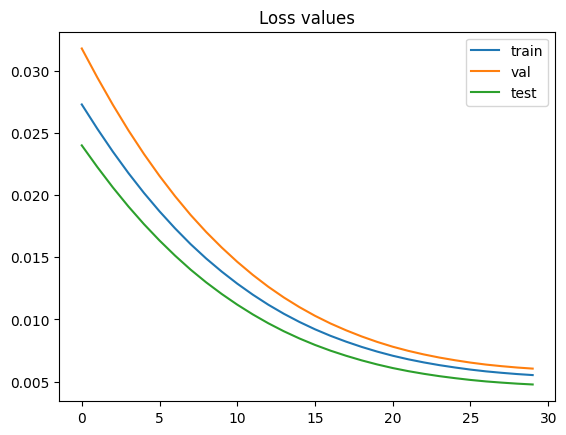

In [78]:
import matplotlib.pyplot as plt
for set in losses:
    plt.plot(losses[set])
plt.legend(losses.keys())
plt.title("Loss values")
plt.show()

## K-fold cross validation

In [37]:
device = torch.device("cuda:0")
loss_fn = torch.nn.MSELoss(reduction="mean")

In [38]:
from torch_geometric.loader import HGTLoader

def get_loaders(train_data, train_index, val_index, batch_size):
    
    train_loader = HGTLoader(
        train_data,
        # Sample 10_000_000 nodes per type and per batch for 1 hop
        num_samples={key: [batch_size*10_000_000] for key in data.node_types},
        batch_size=batch_size,
        input_nodes=('model', train_index),
    )

    val_loader = HGTLoader(
        train_data,
        num_samples={key: [batch_size*10_000_000] for key in data.node_types},
        batch_size=batch_size,
        input_nodes=('model', val_index),
    )

    hetero_train_loader_iterator = iter(train_loader)
    hetero_val_loader_iterator = iter(val_loader)
    
    return (list(hetero_train_loader_iterator), list(hetero_val_loader_iterator))
    

In [116]:
import copy
def train_k(train_loader, hyperparameters):
    global device
    model = copy.deepcopy(hyperparameters["model"]).to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr = hyperparameters["lr"], weight_decay=hyperparameters["wd"])
    loss_list = []
    for epoch in tqdm(range(hyperparameters["epochs"])):
        acc_loss = 0
        batch_size = 0 
        optim.zero_grad()
        for batch in train_loader:
            batch = batch.to(device)
            model.train()
            out =  model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            loss = loss_fn(out["model"].squeeze(),batch["model"].y)
            acc_loss += loss.item()
            batch_size += batch["model"].x.shape[0]
        loss.backward()
        optim.step()
        loss_list.append(acc_loss / batch_size)        
        
    return model, np.array(loss_list)

In [117]:
from sklearn.metrics import root_mean_squared_error

def evaluate_k(model, val_loader):
    global device
    model = model.to(device)
    with torch.inference_mode():
        true_target_values = []
        pred_target_values = []
        
        for batch in val_loader:
            batch = batch.to(device)
            model.eval()
            pred = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            true_target_values.append(batch["model"].y.unsqueeze(0))
            pred_target_values.append(pred["model"].squeeze().unsqueeze(0))
            
        true_target_values = torch.cat(true_target_values, 1)
        pred_target_values = torch.cat(pred_target_values, 1)
        
        score = root_mean_squared_error(true_target_values.cpu().numpy(),pred_target_values.cpu().numpy())
        return score

In [ ]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from torch_geometric.nn import to_hetero

def check_hyperparams(train_data, hyperparameters, train_indices):
    k_fold = KFold(n_splits=5, random_state=0, shuffle=True)
    
    scores = []
    for i, (train_index, val_index) in enumerate(k_fold.split(train_indices)):
        train_index = train_indices[train_index]
        val_index = train_indices[val_index]
        train_loader, val_loader = get_loaders(train_data, train_index, val_index, hyperparameters["batch_size"])
        model, loss_list = train_k(train_loader, hyperparameters)
        score = evaluate_k(model, val_loader)
        scores.append(score)
    return np.mean(scores)

def find_best_model(train_data, hyperparameter_list, train_indices):
    best_score = float("inf")
    best_hyperparams = None
    for hyperparameters in tqdm(hyperparameter_list):
        score = check_hyperparams(train_data, hyperparameters, train_indices)
        if score < best_score:
            best_hyperparams = hyperparameters
            best_score = score
    return best_hyperparams, best_score

## We could also integrate here something fancier like hyperopt but for now lets stick to grid search
# epochs_list = [50, 100, 150]
# batch_size_list = [64, 128, 256]
# aggr_list = ["sum"]
# heads_list = [4,6,8]
# hidden_dim_list = [32, 64, 128]
# dropout_list = [0, .2]
# wd_list = [0, 5e-5]
# lr_list = [3e-3, 3e-4, 3e-5]

epochs_list = [50, 100, 150]
batch_size_list = [128]
aggr_list = ["sum"]
heads_list = [4,6,8]
hidden_dim_list = [32, 64, 128]
dropout_list = [0, .2]
wd_list = [0, 5e-5]
lr_list = [3e-3, 3e-4, 3e-5]

def get_hyperparamer_list(epochs_list, batch_size_list, aggr_list, heads_list, hidden_dim_list, dropout_list, wd_list, lr_list):
    hyperparameter_list = []
    for epochs in epochs_list:
        for batch_size in batch_size_list:
            for aggr in aggr_list:
                for heads in heads_list:
                    for hidden_dim in hidden_dim_list:
                        for dropout in dropout_list:
                            for wd in wd_list:
                                for lr in lr_list:
                                    aggr = aggr
                                    torch.manual_seed(0)
                                    model = GNN(heads = heads, hidden_dim=hidden_dim, dropout=dropout)
                                    model = to_hetero(model, data.metadata(), aggr = aggr).to(device)
                                    
                                    hyperparameters = dict({})
                                    hyperparameters["batch_size"] = batch_size
                                    hyperparameters["epochs"] = epochs
                                    hyperparameters["model"] = model
                                    hyperparameters["lr"] = lr
                                    hyperparameters["wd"] = wd
                                    hyperparameter_list.append(hyperparameters)
    return hyperparameter_list
    
hyperparameter_list = get_hyperparamer_list(epochs_list, batch_size_list, aggr_list, heads_list, hidden_dim_list, dropout_list, wd_list, lr_list)
best_hyperparams, best_score = find_best_model(data, hyperparameter_list, train_indices)

  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
best_hyperparams, best_score

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title("Train loss")
    plt.ylabel("Loss in MSE")
    plt.xlabel("Epochs")
    plt.grid()
    plt.show()

def refit(train_loader, hyperparameters):
    model, loss_list = train_k(train_loader, hyperparameters)
    return model, loss_list

def reevaluate(model, test_loader):
    score = evaluate_k(model, test_loader)
    return score
    
def final_train_and_evaluate(train_loader, test_loader, hyperparameters):
    global train_indices, test_indices
    model, loss_list = refit(train_loader, hyperparameters)
    train_score_after_training = reevaluate(model, train_loader)
    score = reevaluate(model, test_loader)
    plot_loss(loss_list)
    print(f"Final evaluation score is: {format(score, '.4f')}")
    print(f"Train evaluation score after: {format(train_score_after_training, '.4f')} training.")
    return loss_list

train_index = train_indices
test_index = test_indices
train_loader, test_loader = get_loaders(data, train_index, test_index, hyperparameters["batch_size"])
print(f"Train evaluation score before: {format(reevaluate(model, test_loader), '.4f')} training.")
loss_list = final_train_and_evaluate(train_loader, test_loader, best_hyperparams)

## Test for Cross validaion index translator

In [43]:
k_fold = KFold(n_splits=5)
for (idx, val_idx) in k_fold.split(train_indices):
    print(30*"#")
    # print(train_indices[idx])
    # print(train_indices[val_idx])

    ##test
    sorted_k_folds = torch.sort(torch.cat([train_indices[idx], train_indices[val_idx]], 0))[0]
    sorted_all_indices = torch.sort(train_indices)[0]
    mathing_indices = (sorted_all_indices == sorted_k_folds).sum()
    print(mathing_indices == train_indices.shape[0])

##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)


## Empty GPU memory

In [166]:
del model, loss_fn, optim
torch._C._cuda_clearCublasWorkspaces()
torch._dynamo.reset()
import gc
gc.collect()
torch.cuda.empty_cache()

## Base model

In [126]:
from sklearn.model_selection import train_test_split

##TODO change to train,. test val indices form above
X_train, X_test , y_train, y_test = train_test_split(model_and_target_features, target_labels, random_state=0)

In [127]:
from xgboost import XGBRegressor

booster = XGBRegressor()
booster.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [128]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_train, booster.predict(X_train)), mean_squared_error(y_test, booster.predict(X_test))

(0.08159437717968958, 0.7165360300087269)

## Old code

In [ ]:
raise Exception("Keep cell outputs here")

In [133]:
# pivot_targets = pd.pivot_table(targets, values="LN_IC50", index=["SANGER_MODEL_ID"],
#                        columns=['DRUG_ID'])

# pd.merge(targets.loc[:, ["SANGER_MODEL_ID",'PUTATIVE_TARGET', 'PATHWAY_NAME', 'MIN_CONC', 'MAX_CONC']], pivot_targets, on=["SANGER_MODEL_ID","SANGER_MODEL_ID"])

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,...,NaN,2.366388,NaN,NaN,NaN,NaN,NaN,NaN,7.846626,10.613759
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.723942,5.240599,4.432934,4.716167,4.285911,7.793623,9.156372,7.568813,7.063871
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,...,4.879849,1.901766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,2.133421,4.578782,3.893851,3.137208,2.719145,8.871504,9.302207,6.655762,9.441838
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.880307,5.137711,4.863771,5.007426,5.389040,10.462131,9.801610,8.228663,10.817398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242031,GDSC2,401,19187490,1659928,SNU-175,SIDM00216,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,1.310061,5.423870,5.397164,5.401524,4.973343,9.264933,9.211173,7.445385,10.134495
242032,GDSC2,401,19187943,1660034,SNU-407,SIDM00214,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.628609,5.042005,5.055076,4.918666,4.122141,11.121460,9.528520,8.344004,8.575555
242033,GDSC2,401,19188201,1660035,SNU-61,SIDM00194,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.866949,6.130028,5.649833,4.392357,4.382946,10.879932,10.092187,7.743591,10.520666
242034,GDSC2,401,19188741,1674021,SNU-C5,SIDM00498,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.653533,6.151265,6.022426,5.661197,4.820414,9.652950,10.181355,7.305220,10.701430


In [79]:
# ~pivot_targets.isnull()

DRUG_ID,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00003,True,True,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
SIDM00023,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00040,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00041,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00042,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01248,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01251,True,True,True,True,True,False,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01259,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True


## Questions
- Which features from mutations and genes I listed are irrelevant? If unknown pick all but probably I have some that does not make sense to include
  => Main goal: Just run with all
  (=> List with classical oncogenes, tummor suppressor genes)
- What is our goal/baseline? => feature selector from Johannes or paper https://academic.oup.com/bib/article/23/3/bbac100/6554594 (can create one but probably you have one)
- Which metric? IC 50 -> root mean squared error, R2-> 0.9 / 0.96
- Label as LN_IC50? IC50
- Defaul test dataset oder k-fold CV? 10 fold vs LOO-CV? 
- Depth vs Breadth? Bei dem Drug bleiben und versuchen zu verbessern (neue Architekturen, Batching etc) oder Lieber den kompletten graphen mit allen drugs und ziel edge attribute regression? Lieber ersteres da unabhängigkeit zwischen medikamenten
- Edge regression task preferred?:
x = ...  # Node feature matrix: [num_nodes, num_features]
edge_index = ... # Edge indices: [2, num_edges
- What is the goal paper for johannes]

src, dst = edge_index
score = (x[src] * x[dst]).sum(dim=-1)

loss = F.cross_entropy(score, data.edge_label)  # Classification
loss = F.mse_loss(score, data.edge_value)  # Regression

## Problems
	
 CUDA allocation error in training
 
 duplicate model_id + gene_id
 model_name	model_id	symbol	gene_id	chr_name	chr_start	chr_end	total_copy_number	minor_copy_number	loh	...	seg_mean	gene_mean	num_targets	focal	breakpoints	num_snps	gatk_mean_log2_copy_ratio	comment	source	data_type
0	MEC-1	SIDM00001	ABCB1	SIDG00064	chr7	87503966	87600461	3.0	1.0	False	...	0.599167	0.414125	28.0	False	0.0	1124.0	0.574127	POOR GOF (70.4%)	Sanger	WES
844	MEC-1	SIDM00001	ABCB1	SIDG00064	chr7	87503966	87600461	3.0	1.0	False	...	0.551774	0.692527	

-> pre-filter? highest POF in comment? or take both?